In [25]:
import os

import numpy as np
from matplotlib import pyplot as plt
from skimage import io, transform, util

In [18]:
scan_dir = '../data/scans'
mask_dir = '../data/masks'

# Get the list of scan and mask filenames
scan_files = os.listdir(scan_dir)
mask_files = os.listdir(mask_dir)

# Ensure the filenames match between scans and masks
assert len(scan_files) == len(mask_files), "Number of scans and masks do not match!"
for scan_file, mask_file in zip(scan_files, mask_files):
    assert scan_file == mask_file, f"Scan file {scan_file} does not match mask file {mask_file}!"

In [85]:
def preprocess_scan(scan_path):
    """
    Preprocess an OCT scan image.

    Args:
        scan_path (str): Path to the OCT scan image file.

    Returns:
        numpy.ndarray: Preprocessed OCT scan image as a 2D numpy array
            and pixel intensities normalized to the range [0, 1].
    """
    # Load the OCT scan image as grayscale
    scan = io.imread(scan_path, as_gray=True)
    
    # Normalize pixel intensities to the range [0, 1]
    scan = util.img_as_float(scan)

    return scan

def extract_elm_coords(mask_path):
    """
    Extract the coordinates of the external limiting membrane (ELM) from a mask image.

    Args:
        mask_path (str): Path to the mask image file.

    Returns:
        numpy.ndarray: A 2D numpy array containing the coordinates of the non-zero pixels
            in the binary mask, representing the ELM (yx-plane), sorted in ascending order
            with respect to the first column (y-axis).
    """
    # Load the mask image as grayscale
    mask = io.imread(mask_path, as_gray=True)
    
    # Threshold the mask to create a binary image
    binary_mask = mask > 0.5

    # Find the non-zero pixel coordinates in the binary mask
    elm_coords = np.argwhere(binary_mask)
    
    # Sort the coordinates based on the first column (x-axis)
    sorted_indices = np.argsort(elm_coords[:, 1])
    elm_coords_sorted = elm_coords[sorted_indices]
    
    return elm_coords_sorted


def load_dataset(files, scan_directory, mask_directory):
    """
    Load and preprocess a dataset of OCT scans and corresponding ELM masks.

    Args:
        files (list): List of file names for the OCT scans and masks.
        scan_directory (str): Directory path containing the OCT scan images.
        mask_directory (str): Directory path containing the ELM mask images.

    Returns:
        tuple: A tuple containing two lists:
            - scans: List of preprocessed OCT scan images as 2D numpy arrays.
            - elm_coords_list: List of 2D numpy arrays containing the coordinates of the ELM
                for each corresponding OCT scan.
    """
    scans = []
    elm_coords_list = []
    for file in files:
        scan_path = os.path.join(scan_directory, file)
        mask_path = os.path.join(mask_directory, file)

        # Load and preprocess the OCT scan
        scan = preprocess_scan(scan_path)
        scans.append(scan)

        # Extract the ELM coordinates from the mask
        elm_coords = extract_elm_coords(mask_path)
        elm_coords_list.append(elm_coords)

    return scans, elm_coords_list

In [86]:
scans, elm_list = load_dataset(scan_files, scan_dir, mask_dir)

In [87]:
shapes = [s.shape for s in scans]

In [109]:
idx = 400
ex_scan = scans[idx]
ex_elm = elm_list[idx]

plt.figure(figsize=[10, 10])
plt.imshow(ex_scan, cmap='gist_gray')
plt.scatter(ex_elm[:, 1], ex_elm[:, 0], c='red', s=1, alpha=0.5)
plt.axis()
plt.tight_layout()
plt.show()

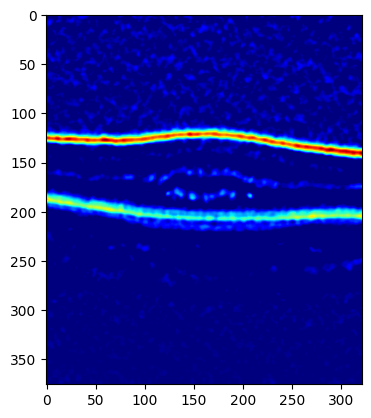

In [110]:
from gpet_oct import utils

# Create a kernel for edge detection
kernel = utils.kernel_builder(size=(21, 5), unit=False, normalize=True)
# Compute the gradient image
ex_grad_scan = utils.comp_grad_img(ex_scan, kernel)

plt.imshow(ex_grad_scan, cmap='jet')

In [111]:
def get_init_from_elm(elm_coords):
    return ex_elm[[0, -1], :][:, [1, 0]]
    
# Get initialization edges from the true_elm_coords aka mask
init = get_init_from_elm(ex_elm)
# Switch rows so the x's are in ascending order
ex_elm[:, 1]

array([  0,   0,   0,   1,   1,   1,   2,   2,   2,   3,   3,   4,   4,
         4,   5,   5,   5,   6,   6,   6,   7,   7,   7,   7,   8,   8,
         8,   8,   9,   9,   9,  10,  10,  10,  11,  11,  11,  12,  12,
        12,  13,  13,  13,  14,  14,  14,  15,  15,  15,  16,  16,  16,
        17,  17,  17,  18,  18,  18,  19,  19,  19,  20,  20,  20,  20,
        21,  21,  21,  21,  22,  22,  22,  23,  23,  23,  24,  24,  24,
        25,  25,  25,  26,  26,  26,  26,  27,  27,  27,  27,  28,  28,
        28,  29,  29,  29,  30,  30,  30,  31,  31,  31,  32,  32,  32,
        32,  33,  33,  33,  33,  34,  34,  34,  35,  35,  35,  36,  36,
        36,  37,  37,  37,  37,  38,  38,  38,  39,  39,  39,  40,  40,
        40,  41,  41,  41,  42,  42,  42,  43,  43,  43,  44,  44,  44,
        45,  45,  45,  46,  46,  46,  47,  47,  47,  48,  48,  49,  49,
        49,  50,  50,  50,  51,  51,  51,  52,  52,  52,  53,  53,  53,
        53,  54,  54,  54,  54,  55,  55,  55,  56,  56,  56,  5

In [112]:
init

array([[  0, 185],
       [320, 201]])

In [96]:
from gpet_oct import gpet
from importlib import reload

reload(gpet)

<module 'gpet_oct.gpet' from '/Users/uzaykaradag/Documents/School/Dissertation/gpr-oct-segmentation/gpet_oct/gpet.py'>

In [97]:
gp_kwargs = dict(
    kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5},
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True
)

# Instantiate algorithm using parameters in __init__()
noisy_trace = gpet.GP_Edge_Tracing(init, ex_grad_scan, **gp_kwargs)

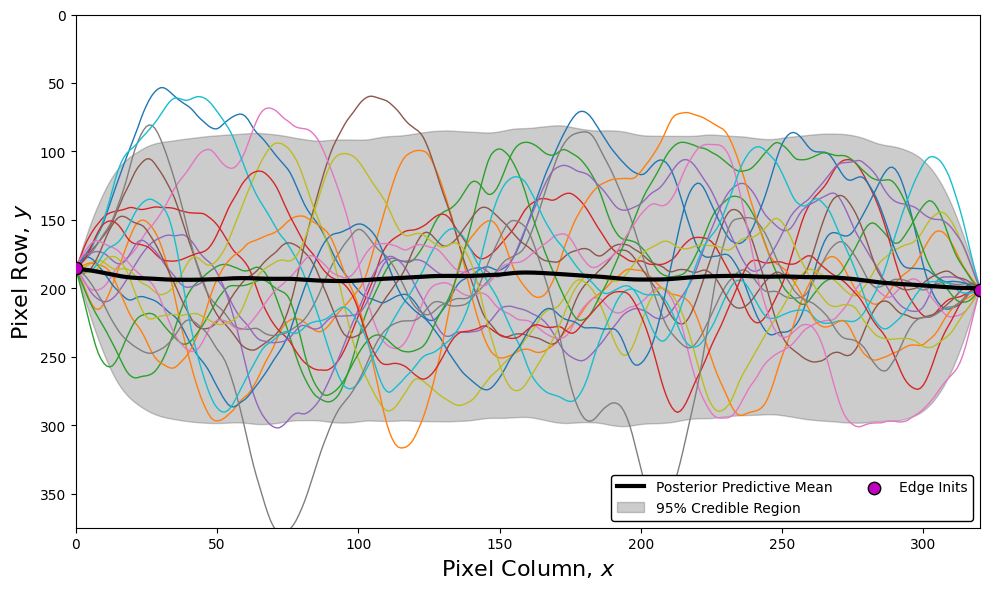

Are you happy with your choice of kernel? y/n
Fitting Gaussian process and computing next set of observations...


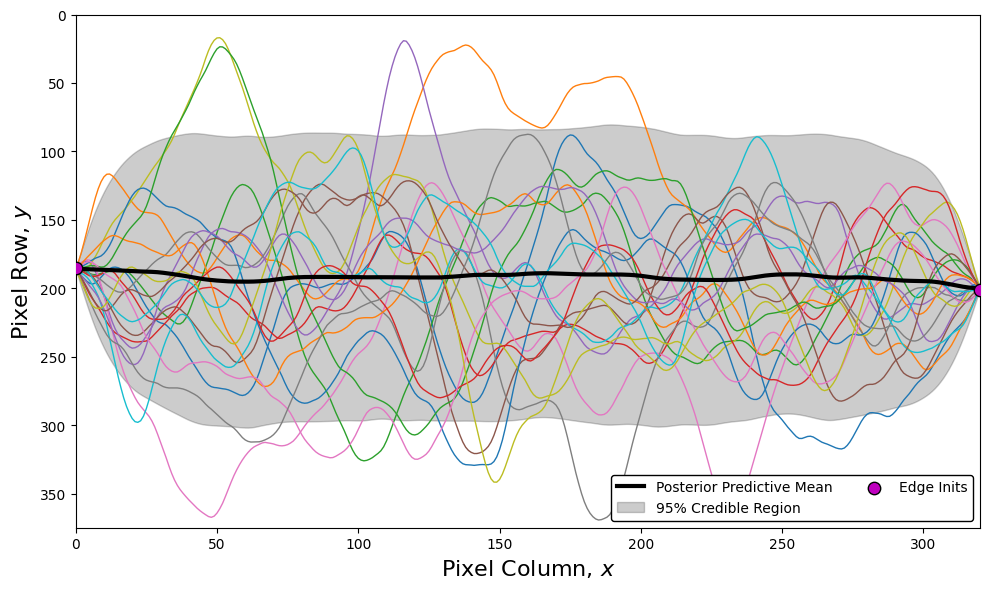

Number of observations: 7
Iteration 2 - Time Elapsed: 1.2723


Fitting Gaussian process and computing next set of observations...


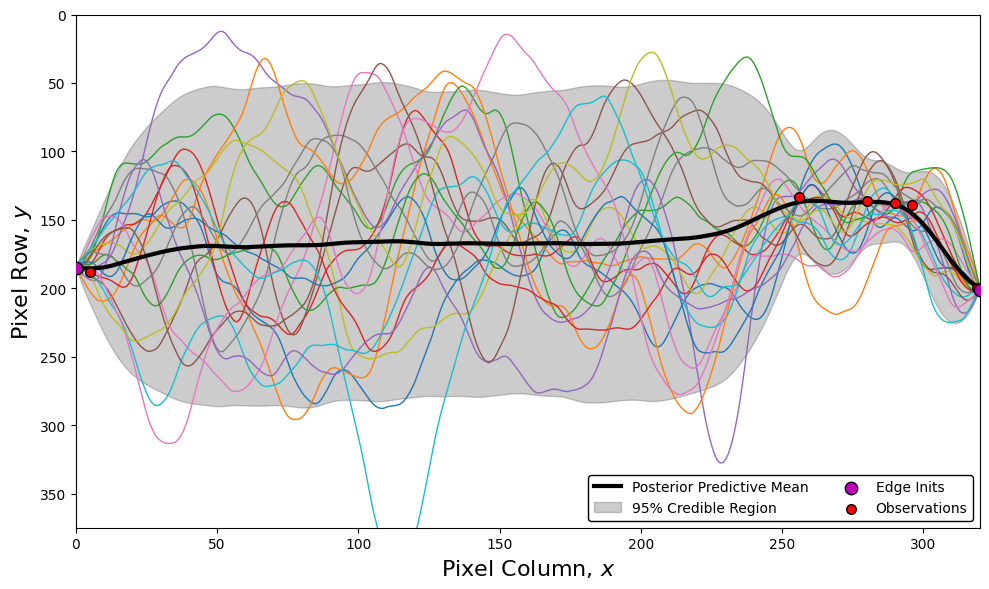

Number of observations: 15
Iteration 3 - Time Elapsed: 0.7819


Fitting Gaussian process and computing next set of observations...


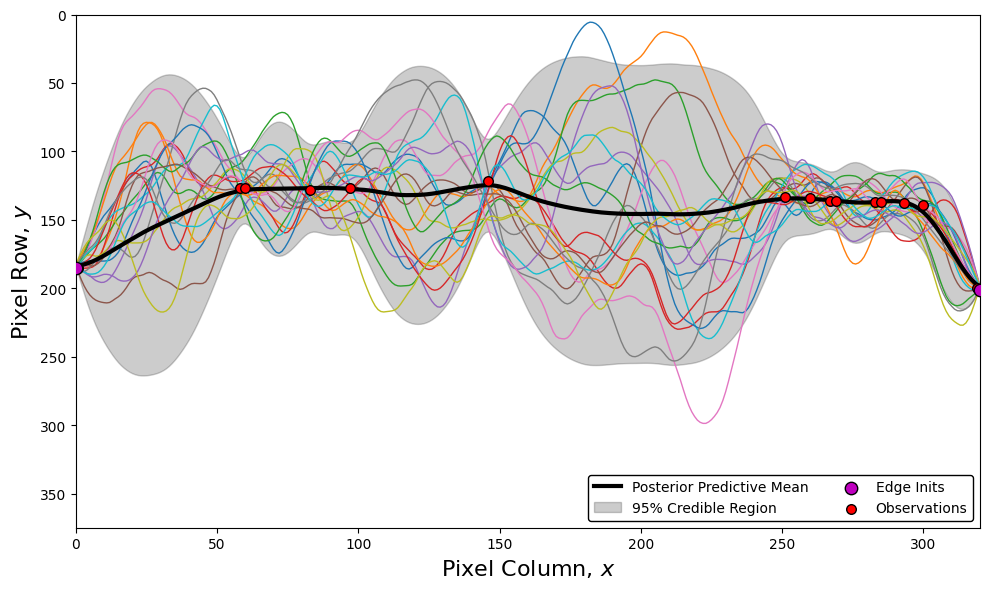

Number of observations: 31
Iteration 4 - Time Elapsed: 0.7527


Fitting Gaussian process and computing next set of observations...


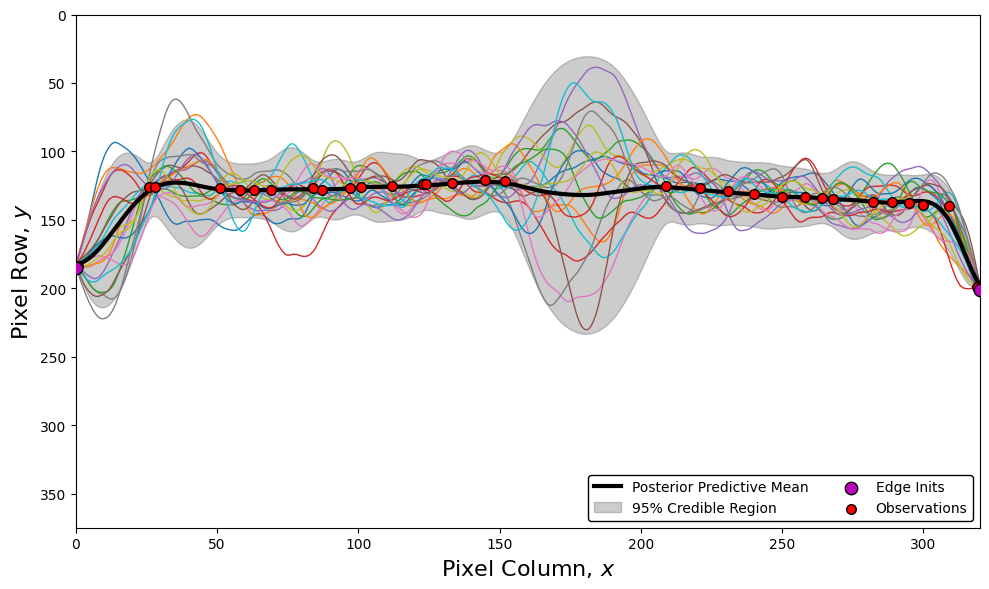

Number of observations: 37
Iteration 5 - Time Elapsed: 0.7309


Time elapsed before algorithm converged: 3.843


In [98]:
# __call__() parameters and run algorithm on test image
print_final_diagnostics = False
show_init_post = True
show_post_iter = True
verbose = True
edge_pred, edge_credint = noisy_trace(print_final_diagnostics,
                                      show_init_post,
                                      show_post_iter,
                                      verbose)

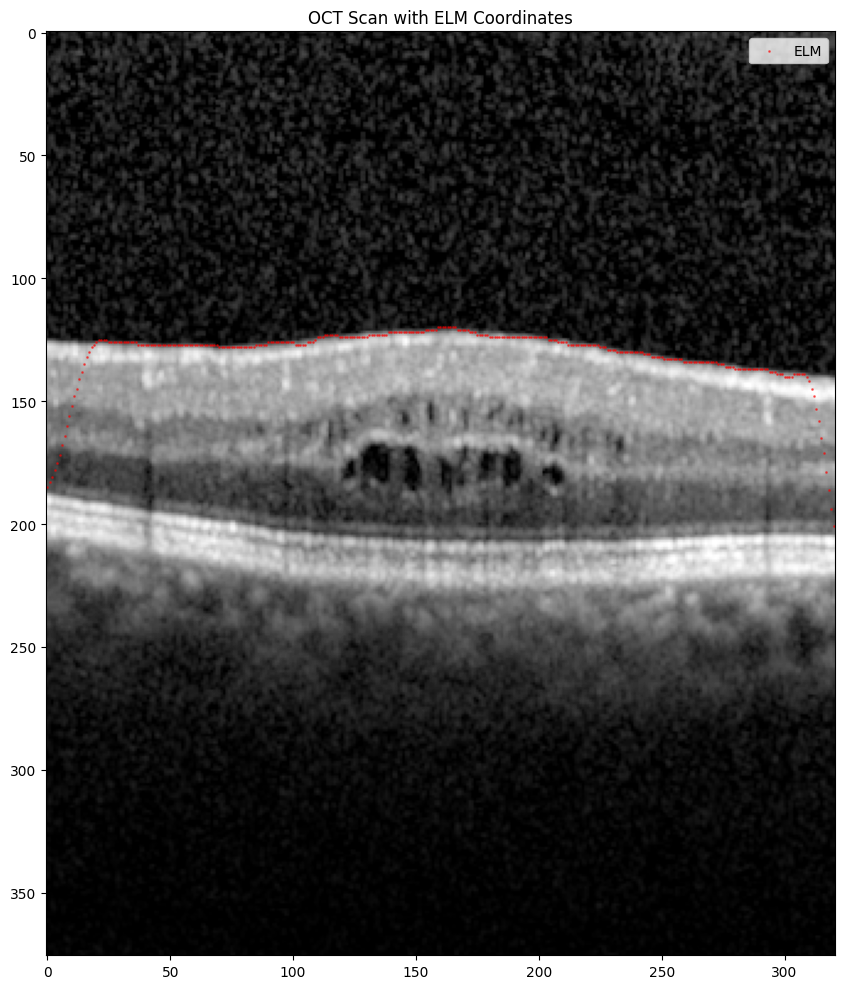

In [102]:
utils.plot_elm(ex_scan, edge_pred)

**The DICE coeff. is very similar for each scans ELM masks hence we can use a mask from a prior image as prior knowledge for the current one while edge tracing**

In [108]:
for i, true_edge in enumerate(elm_list):
    print(utils.trace_dicecoef(elm_list[i], elm_list[i] + 1))
    print('---------------------')
    print(elm_list[i].shape)
    print(elm_list[i].shape)
    print('\n-------------------\n')

0.9998
---------------------
(2237, 2)
(2237, 2)

-------------------

0.9994
---------------------
(1058, 2)
(1058, 2)

-------------------

0.9995
---------------------
(1182, 2)
(1182, 2)

-------------------

0.9994
---------------------
(1018, 2)
(1018, 2)

-------------------

0.9994
---------------------
(1064, 2)
(1064, 2)

-------------------

0.9998
---------------------
(2270, 2)
(2270, 2)

-------------------

0.9995
---------------------
(1194, 2)
(1194, 2)

-------------------

0.9998
---------------------
(2290, 2)
(2290, 2)

-------------------

0.9995
---------------------
(1132, 2)
(1132, 2)

-------------------

0.9998
---------------------
(2302, 2)
(2302, 2)

-------------------

0.9994
---------------------
(1072, 2)
(1072, 2)

-------------------

0.9994
---------------------
(1009, 2)
(1009, 2)

-------------------

0.9994
---------------------
(1026, 2)
(1026, 2)

-------------------

0.9994
---------------------
(1015, 2)
(1015, 2)

-------------------

0.9994

KeyboardInterrupt: 

In [122]:
prior_elm_raw = elm_list[idx - 2]

In [123]:
prior_elm_raw

array([[154,   0],
       [155,   0],
       [153,   0],
       ...,
       [140, 320],
       [138, 320],
       [139, 320]])

In [124]:
ex_scan.shape[1]

321

In [125]:
# Create boolean mask for coordinates within scan boundaries
within_bounds = (prior_elm_raw[:, 0] < ex_scan.shape[1]) & (prior_elm_raw[:, 1] < ex_scan.shape[0])

# Filter coordinates
prior_elm = prior_elm_raw[within_bounds]

prior_elm[:, [0, 1]] = prior_elm[:, [1, 0]]
prior_elm

In [154]:
gp_kwargs = dict(
    kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5},
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True,
    obs = prior_elm
)

# Instantiate algorithm using parameters in __init__()
noisy_trace = gpet.GP_Edge_Tracing(init, ex_grad_scan, **gp_kwargs)

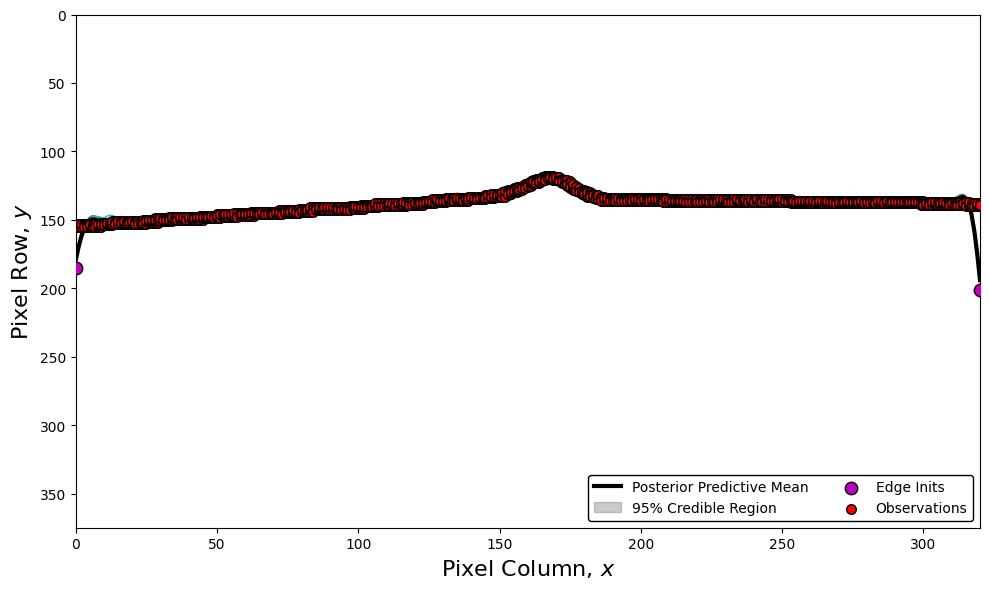

Are you happy with your choice of kernel? y/n
Time elapsed before algorithm converged: 33.623


In [155]:
print_final_diagnostics = False
show_init_post = True
show_post_iter = True
verbose = True
edge_pred, edge_credint = noisy_trace(print_final_diagnostics,
                                      show_init_post,
                                      show_post_iter,
                                      verbose)

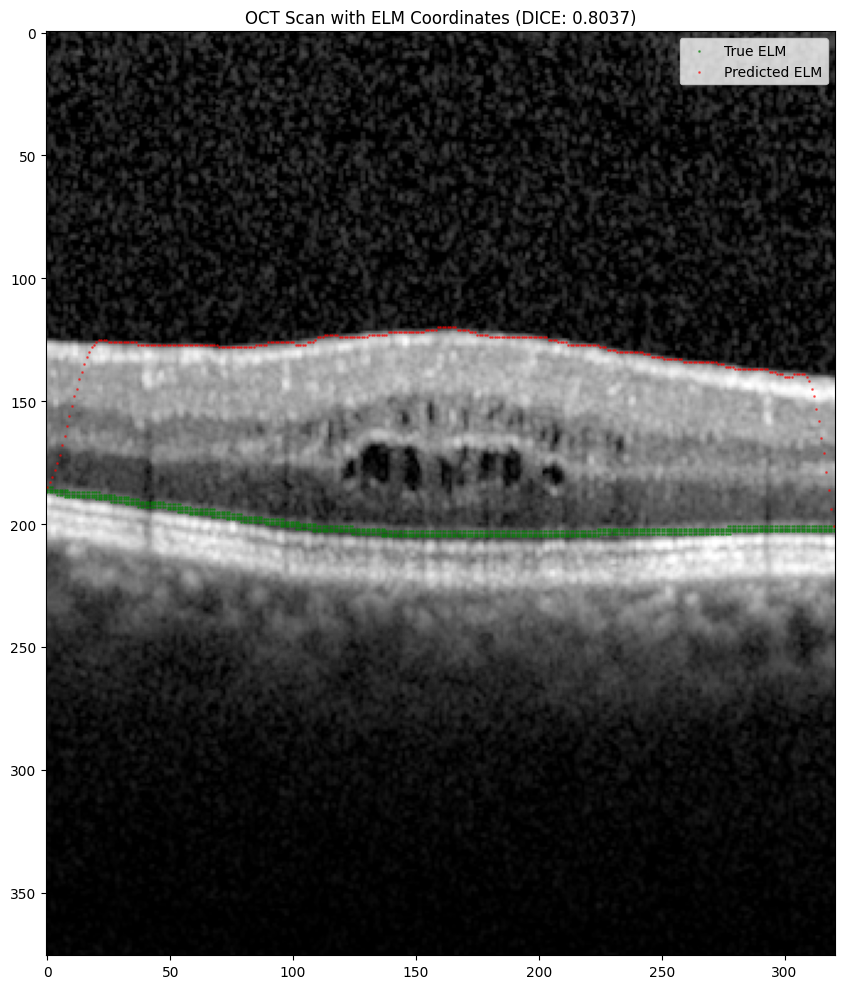

In [138]:
utils.plot_elm(ex_scan, edge_pred, compare=True, true_elm_coords=ex_elm)

In [147]:
s = ex_scan.shape
s

(376, 321)

In [144]:
shapes.index(s)

1

In [145]:
idx

400

In [150]:
similar_idx = [i for i, x in enumerate(shapes) if x==s] # Find the indices for the scans with the same shape

In [158]:
similar_elm = [elm_list[i] for i in similar_idx] # Get all the ELM coordinates lists for the similarly shaped scans
s_elm = similar_elm[300]
s_elm[:, [0, 1]] = s_elm[:, [1, 0]]
s_elm

In [159]:
gp_kwargs = dict(
    kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5},
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True,
    obs = s_elm # similar elm
)

# Instantiate algorithm using parameters in __init__()
noisy_trace = gpet.GP_Edge_Tracing(init, ex_grad_scan, **gp_kwargs)

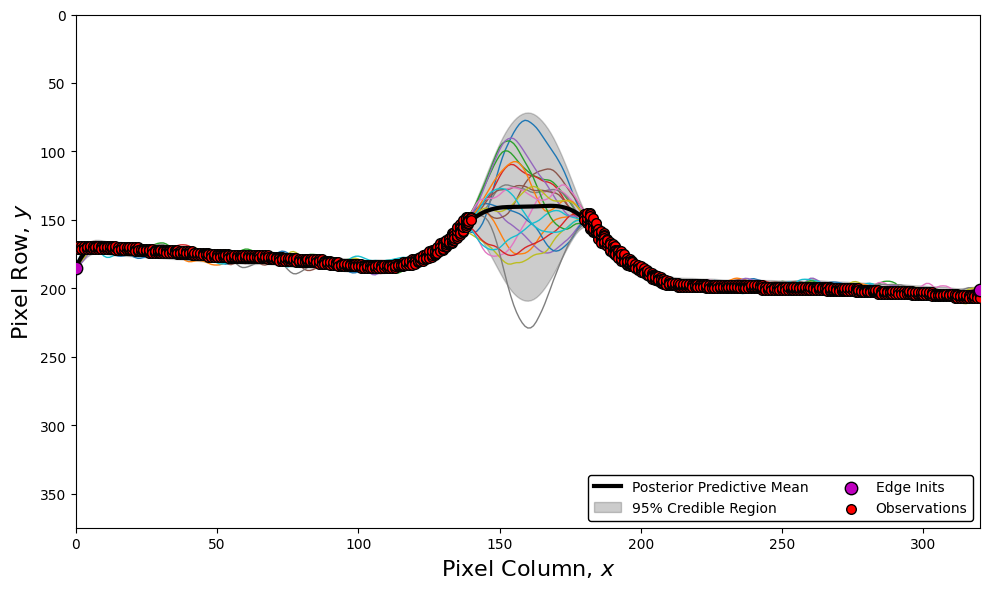

Are you happy with your choice of kernel? y/n


KeyboardInterrupt: 

In [160]:
# __call__() parameters and run algorithm on test image
print_final_diagnostics = False
show_init_post = True
show_post_iter = True
verbose = True
elm_pred, elm_credint = noisy_trace(print_final_diagnostics,
                                      show_init_post,
                                      show_post_iter,
                                      verbose)